# Further resolution tests with $\mathrm{Ra} = 10^9$

## Without hyperviscosity: model crashes at $t = 2.31 \times 10^6$

In [104]:
import xarray as xr
import numpy as np
import dedalus.public as d3
from IPython.display import Video
import matplotlib.pyplot as plt

import modules.math as math

In [37]:
Video('../data/restest_highRa_1024_128/restest_highRa_1024_128_s1.mp4')

This is probably not due to the time step, since $C < 1$ everywhere, except at the point where the model blows up:

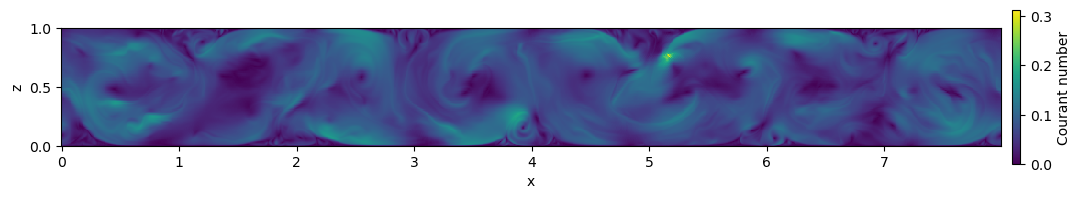

In [14]:
highRa = xr.open_mfdataset(
    '../data/restest_highRa_1024_128/*.nc', 
    chunks={'t': 1000, 'x': 128, 'z': 128})

def courant_number(data):
    diff_x = np.diff(data.x)
    dx = (
        np.concatenate([[diff_x[0]], diff_x])
        + np.concatenate([diff_x, [diff_x[-1]]])
    )/2
    diff_z = np.diff(data.z)
    dz = (
        np.concatenate([[diff_z[0]], diff_z])
        + np.concatenate([diff_z, [diff_z[-1]]])
    )/2
    C = np.sqrt(
        (np.abs(data.u)/np.atleast_2d(dx).T)**2
        + (np.abs(data.w)/np.atleast_2d(dz))**2
    )*data.timestep
    return C

fig, ax = plt.subplots(figsize=(12, 2), sharex=True)
mesh = ax.pcolormesh(
    highRa.x, highRa.z, courant_number(highRa.isel(t=769)).T, vmin=0)
fig.colorbar(mesh, ax=ax, pad=0.01, label='Courant number')
ax.set(aspect='equal', xlabel='x', ylabel='z')
fig.tight_layout()

Here is a close-up of the singularity:

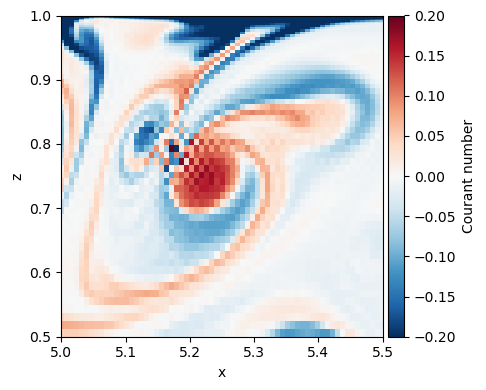

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
mesh = ax.pcolormesh(
    highRa.x, highRa.z, highRa.theta.isel(t=768).T,
    vmin=-0.2, vmax=0.2, cmap='RdBu_r')
fig.colorbar(mesh, ax=ax, pad=0.01, label='Courant number')
ax.set(
    aspect='equal', xlabel='x', ylabel='z', xlim=(5.0, 5.5), ylim=(0.5, 1.0))
fig.tight_layout()

# With hyperviscosity: model crashes at $t = 1.97 \times 10^6$
I now add 4th-order hyperviscosity terms $-\tilde{\nu} \nabla^4$ to the momentum and energy equations, choosing the hyperviscosity coefficient $\tilde{\nu} = 10^{-7}$. In order to avoid needing to specify additional boundary conditions, the hyperviscosity is reduced to zero at the boundaries using a factor $f(z) = 1 - (2z - 1)^{10}$. The equations in full are

$$
\begin{align*}
    \mathrm{Ra}\,\mathrm{Pr}^{-1} \left( \partial_t \vec{u} + \vec{u} \cdot \vec{\nabla} \vec{u} \right)
        &= -\vec{\nabla} \pi + \nabla^2 \vec{u} - \tilde{\nu} f(z) \nabla^4 \vec{u} + \theta \hat{z}, \\
    \mathrm{Ra} \left( \partial_t \theta + \vec{u} \cdot \vec{\nabla} \theta \right)
        &= \nabla^2 \theta - \tilde{\nu} f(z) \nabla^4 \theta, \\
    \vec{\nabla} \cdot \vec{u} &= 0
\end{align*}
$$

In [19]:
Video('../data/restest_highRa_hyper/restest_highRa_hyper_1024_128/restest_highRa_hyper_1024_128_s1.mp4')

Checking the data in coefficient space confirms that there is an accumulation of power in the high-wavenumber modes at the point that the model crashes:

In [201]:
data = xr.open_dataset('../data/restest_highRa_hyper/restest_highRa_hyper_1024_128/restest_highRa_hyper_1024_128_s1.nc')

/srv/ccrc/AtmSS/z5310829/miniconda3/envs/hons/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


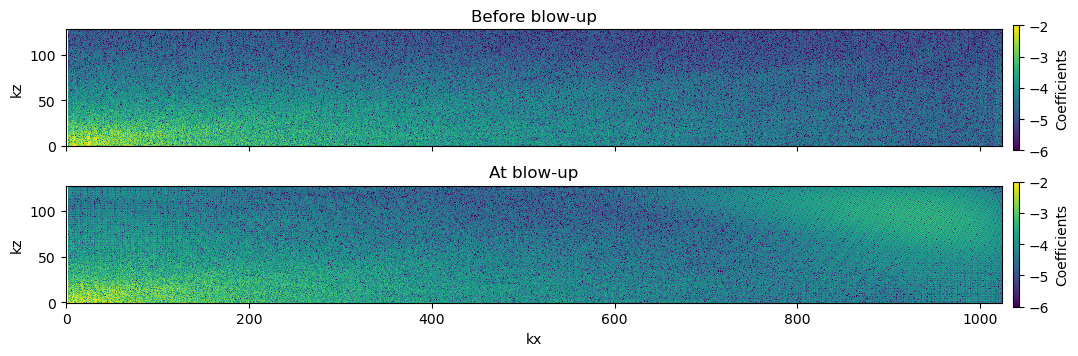

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(12, 3.5), sharex=True)

coef = transforms.space_coefficients(data.theta.isel(t=500))
mesh = axes[0].pcolormesh(
    coef.kx, coef.kz, np.log10(np.abs(coef)).T, vmin=-6, vmax=-2)
fig.colorbar(mesh, ax=axes[0], pad=0.01, label='Coefficients')
axes[0].set(aspect='equal', ylabel='kz', title='Before blow-up')

coef = transforms.space_coefficients(data.theta.isel(t=656))
mesh = axes[1].pcolormesh(
    coef.kx, coef.kz, np.log10(np.abs(coef)).T, vmin=-6, vmax=-2)
fig.colorbar(mesh, ax=axes[1], pad=0.01, label='Coefficients')
axes[1].set(aspect='equal', xlabel='kx', ylabel='kz', title='At blow-up')

fig.tight_layout()


### Checking the magnitude of each term in the equations: before blow-up

In [209]:
i_time = 500
Rayleigh = 1e9
Prandtl = 1
hyper = 1e-7

calculator = math.Math(1024, 128)

u = calculator.array_to_field(data.u.isel(t=i_time))
w = calculator.array_to_field(data.w.isel(t=i_time))
theta = calculator.array_to_field(data.theta.isel(t=i_time))

taper = calculator.dist.Field(name='taper', bases=calculator.zbasis)
taper['g'] = 1 - (2*calculator.z - 1)**10

u_terms = {
    'advection': (
        u * d3.Differentiate(u, calculator.coords['x'])
        + w * d3.Differentiate(u, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(u)*Prandtl/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(u))
    )*Prandtl/Rayleigh
}
w_terms = {
    'advection': (
        u * d3.Differentiate(w, calculator.coords['x'])
        + w * d3.Differentiate(w, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(w)*Prandtl/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(w))
    )*Prandtl/Rayleigh,
    'buoyancy': theta*Prandtl/Rayleigh
}
theta_terms = {
    'advection': (
        u * d3.Differentiate(theta, calculator.coords['x'])
        + w * d3.Differentiate(theta, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(theta)/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(theta))
    )/Rayleigh
}

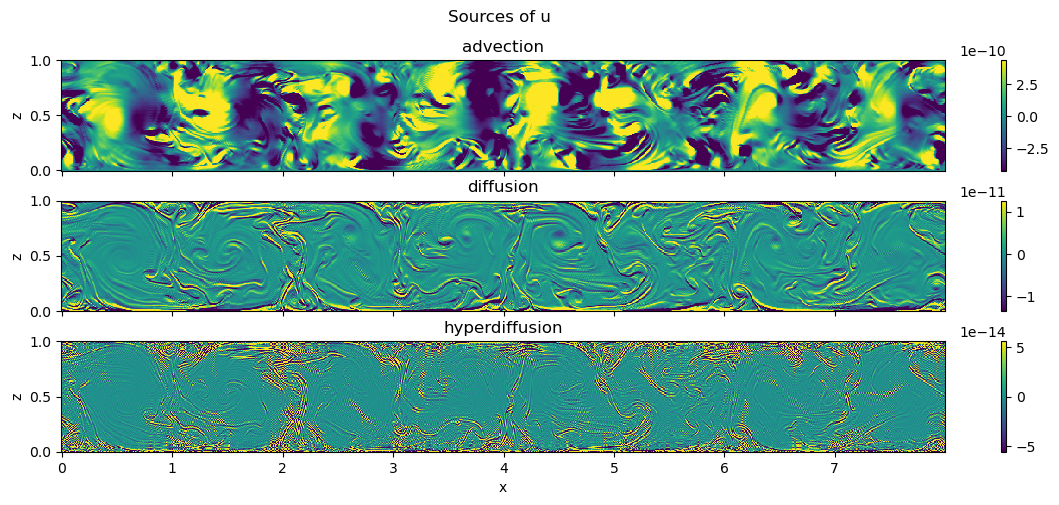

In [203]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(np.quantile(array, 0.1), np.quantile(array, 0.9))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle('Sources of u', x=0.43)
fig.tight_layout()

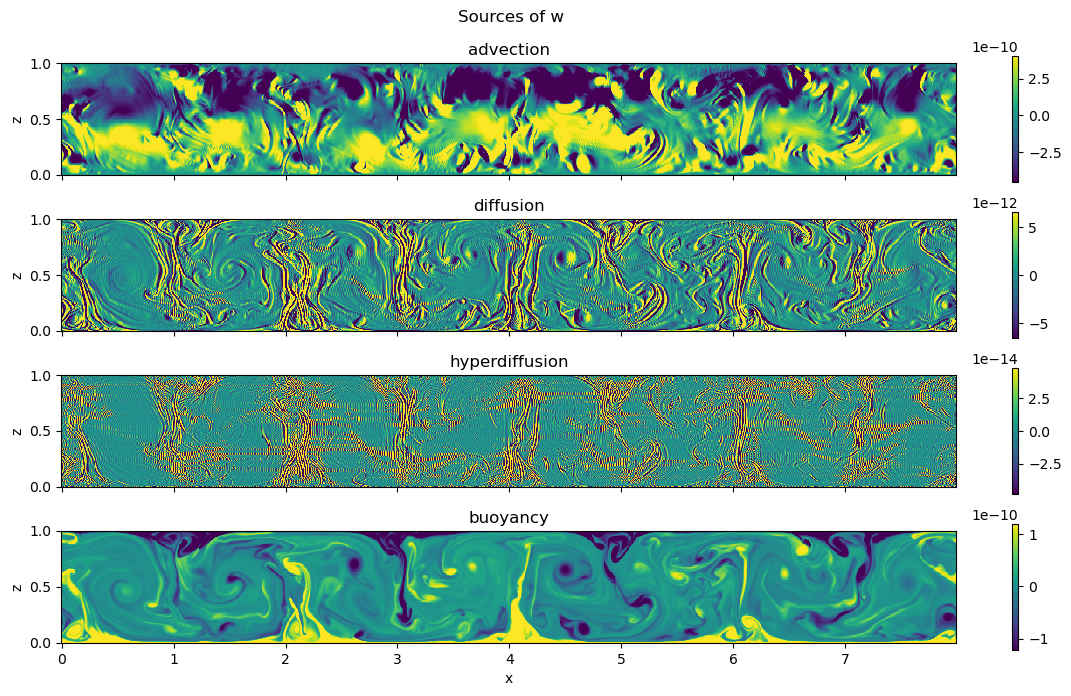

In [210]:
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(np.quantile(array, 0.1), np.quantile(array, 0.9))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle('Sources of w', x=0.43)
fig.tight_layout()

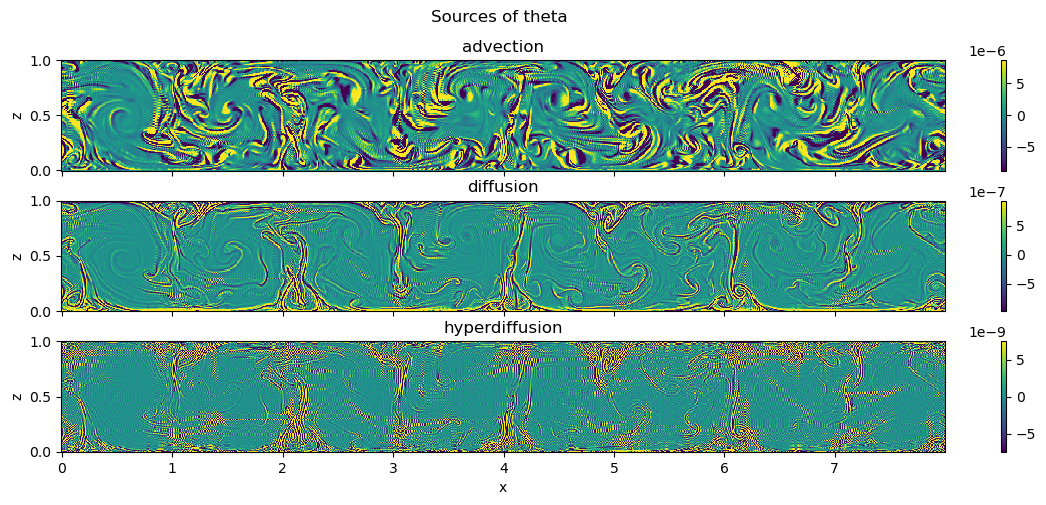

In [208]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(np.quantile(array, 0.1), np.quantile(array, 0.9))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle('Sources of theta', x=0.43)
fig.tight_layout()